/Users/chinmaysultanpuri/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- 1. Loading and Preparing Data ---

Full dataset distribution (variants vs. emotions):
emotion_label  angry  happy  neutral  sad
variant                                  
emotional         95     95        0   95
neutral           95     95      150   95

Probing with 435 samples for variant 'neutral'.

Class distribution for this variant:
emotion_label
neutral    150
happy       95
sad         95
angry       95
Name: count, dtype: int64
Class balance ratio: 0.63

Label mapping: {0: 'angry', 1: 'happy', 2: 'neutral', 3: 'sad'}

--- 2. Loading Model and Extracting Hidden States ---
Using device: cpu


The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Extracting Hidden States:   0%|          | 0/435 [00:00<?, ?it/s]


Last 5 tokens of first sample: ['▁state', '▁of', '▁this', '▁user', '▁is']
The probe will use the vector for the token: '▁is'


Extracting Hidden States: 100%|██████████| 435/435 [28:29<00:00,  3.93s/it]



Saving hidden states to cache...

--- 3. Training Probes (Logistic Regression Classifiers) ---


Training Probes: 100%|██████████| 27/27 [00:31<00:00,  1.18s/it]




--- 4. Analysis and Visualization ---
Best probe performance (by accuracy) found at Layer 14 with accuracy: 0.9770

Layer-wise Performance Summary:
  Embeddings: Acc=0.345, F1-Macro=0.128
     Layer 1: Acc=0.851, F1-Macro=0.840
     Layer 2: Acc=0.885, F1-Macro=0.874
     Layer 3: Acc=0.885, F1-Macro=0.875
     Layer 4: Acc=0.874, F1-Macro=0.863
     Layer 5: Acc=0.908, F1-Macro=0.899
     Layer 6: Acc=0.908, F1-Macro=0.898
     Layer 7: Acc=0.885, F1-Macro=0.872
     Layer 8: Acc=0.920, F1-Macro=0.911
     Layer 9: Acc=0.920, F1-Macro=0.908
    Layer 10: Acc=0.931, F1-Macro=0.924
    Layer 11: Acc=0.931, F1-Macro=0.924
    Layer 12: Acc=0.943, F1-Macro=0.937
    Layer 13: Acc=0.943, F1-Macro=0.937
    Layer 14: Acc=0.977, F1-Macro=0.974
    Layer 15: Acc=0.977, F1-Macro=0.974
    Layer 16: Acc=0.966, F1-Macro=0.960
    Layer 17: Acc=0.966, F1-Macro=0.960
    Layer 18: Acc=0.977, F1-Macro=0.974
    Layer 19: Acc=0.966, F1-Macro=0.960
    Layer 20: Acc=0.977, F1-Macro=0.974
    Layer 

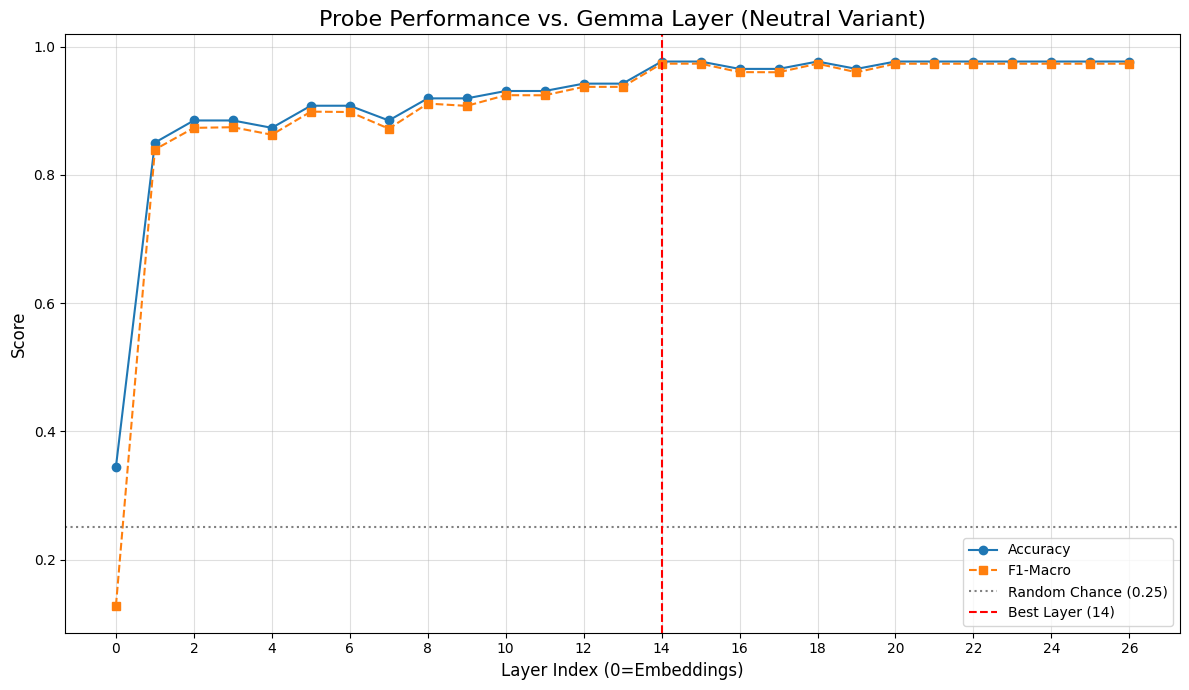


--- Detailed Analysis for Best Layer (14) ---
Average prediction confidence on test set: 0.993 (Std: 0.029)


/var/folders/_k/vbkl_k7n1v132xrv3mf0f83r0000gn/T/ipykernel_60389/2338528899.py:202: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette='viridis')


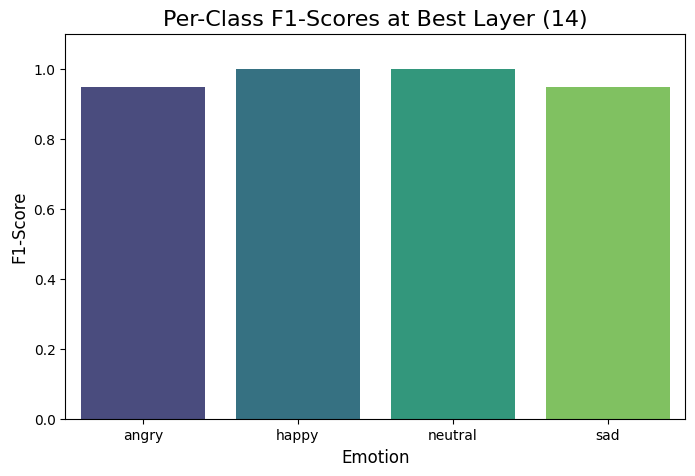

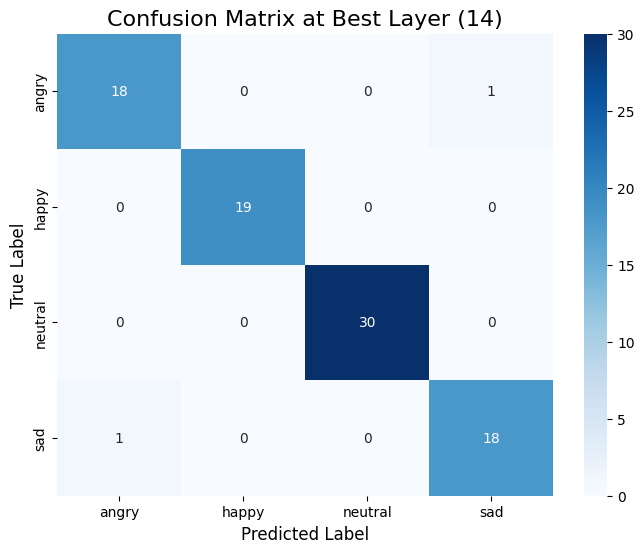



--- 5. Next Steps and Further Research ---
This run analyzed the 'neutral' variant.
To compare with the other variant, change the 'VARIANT_TO_PROBE' variable at the top of the script to 'neutral' (or 'emotional') and re-run.
The script will create a separate cache directory and generate new plots, allowing you to directly compare the results.
This will help answer: Can emotion be decoded even from 'neutralized' conversations?

--- End of Analysis ---


In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import pickle
import warnings

# Suppress common warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

# --- 0. Setup and Configuration ---

# --- Configuration ---
MODEL_NAME = "google/gemma-3-1b-it"
DATA_FILE = 'data.csv'  # <-- This will now use your data.csv file
ELICITATION_PROMPT = "I think the emotional state of this user is"
VARIANT_TO_PROBE = "neutral" # <-- Key parameter: change to 'neutral' for comparison run
RANDOM_STATE = 42
TEST_SPLIT_SIZE = 0.2
CACHE_HIDDEN_STATES = True
# Variant-specific cache to allow for easy comparison runs
CACHE_DIR = f"hidden_states_cache_{VARIANT_TO_PROBE}"

# --- 1. Data Loading and Preparation ---

print("--- 1. Loading and Preparing Data ---")
df = pd.read_csv(DATA_FILE)

# ENHANCED ANALYSIS: Show full dataset distribution
print("\nFull dataset distribution (variants vs. emotions):")
variant_emotion_counts = df.groupby(['variant', 'emotion_label']).size().unstack(fill_value=0)
print(variant_emotion_counts)

# Filter for the specific variant you want to probe
df_filtered = df[df['variant'] == VARIANT_TO_PROBE].copy()

if len(df_filtered) == 0:
    raise ValueError(f"No samples found for variant '{VARIANT_TO_PROBE}'. Please check your CSV file.")
print(f"\nProbing with {len(df_filtered)} samples for variant '{VARIANT_TO_PROBE}'.")

# ENHANCED IMBALANCE CHECK
print("\nClass distribution for this variant:")
class_counts = df_filtered['emotion_label'].value_counts()
print(class_counts)
if class_counts.min() > 0:
    balance_ratio = class_counts.min() / class_counts.max()
    print(f"Class balance ratio: {balance_ratio:.2f}")
    if balance_ratio < 0.7:
        print("Warning: Dataset is moderately imbalanced. Consider using `class_weight='balanced'` in LogisticRegression.")

df_filtered['full_prompt'] = df_filtered['conversation'].apply(lambda conv: f"{conv}\n\n{ELICITATION_PROMPT}")
df_filtered['emotion_code'] = df_filtered['emotion_label'].astype('category').cat.codes
labels = df_filtered['emotion_code'].values
label_map = dict(enumerate(df_filtered['emotion_label'].astype('category').cat.categories))
num_classes = len(label_map)
print(f"\nLabel mapping: {label_map}")


# --- 2. Model Loading and Hidden State Extraction ---

all_hidden_states = {}
cache_files_exist = False

# ROBUST CACHING LOGIC
if CACHE_HIDDEN_STATES and os.path.exists(CACHE_DIR):
    try:
        cache_files = [f for f in os.listdir(CACHE_DIR) if f.startswith('layer_') and f.endswith('.pkl')]
        if len(cache_files) > 0:
            # Sort numerically, not alphabetically (e.g., layer_10 after layer_9)
            cache_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
            print(f"\n--- 2. Loading {len(cache_files)} Cached Hidden State Files ---")
            for filename in tqdm(cache_files, desc="Loading from cache"):
                layer_idx = int(filename.split('_')[1].split('.')[0])
                with open(os.path.join(CACHE_DIR, filename), 'rb') as f:
                    data = pickle.load(f)
                    all_hidden_states[layer_idx] = data['X']
            
            # Verify that we loaded states for the correct number of samples
            if len(next(iter(all_hidden_states.values()))) == len(labels):
                num_layers = len(all_hidden_states) - 1
                print(f"Successfully loaded hidden states for {num_layers + 1} layers.")
                cache_files_exist = True
            else:
                print("Warning: Cache data size mismatch. Re-extracting states.")
                all_hidden_states = {} # Clear partial cache
    except (IOError, pickle.UnpicklingError, IndexError) as e:
        print(f"Warning: Could not load cache files due to an error: {e}. Re-extracting states.")

if not cache_files_exist:
    print("\n--- 2. Loading Model and Extracting Hidden States ---")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, output_hidden_states=True, torch_dtype=torch.bfloat16).to(device)
    model.eval()

    num_layers = model.config.num_hidden_layers
    all_hidden_states = {i: [] for i in range(num_layers + 1)}

    with torch.no_grad():
        for idx, text in enumerate(tqdm(df_filtered['full_prompt'], desc="Extracting Hidden States")):
            inputs = tokenizer(text, return_tensors="pt").to(device)
            if idx == 0:
                tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
                print(f"\nLast 5 tokens of first sample: {tokens[-5:]}")
                print(f"The probe will use the vector for the token: '{tokens[-1]}'")
            
            outputs = model(**inputs)
            for layer_idx, layer_states in enumerate(outputs.hidden_states):
                all_hidden_states[layer_idx].append(layer_states[0, -1, :].cpu().float().numpy())
    
    for i in range(num_layers + 1):
        all_hidden_states[i] = np.array(all_hidden_states[i])

    if CACHE_HIDDEN_STATES:
        print("\nSaving hidden states to cache...")
        os.makedirs(CACHE_DIR, exist_ok=True)
        for layer_idx, states in all_hidden_states.items():
            with open(os.path.join(CACHE_DIR, f"layer_{layer_idx}.pkl"), "wb") as f:
                pickle.dump({'X': states}, f)

# --- 3. Training Probes for Each Layer ---

print("\n--- 3. Training Probes (Logistic Regression Classifiers) ---")
probe_accuracies, probe_f1_macros = [], []

for layer_idx in tqdm(range(num_layers + 1), desc="Training Probes"):
    X, y = all_hidden_states[layer_idx], labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT_SIZE, random_state=RANDOM_STATE, stratify=y)
    
    # If your dataset were severely imbalanced, you would use this line instead:
    # probe = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight='balanced')
    probe = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    probe.fit(X_train, y_train)
    
    y_pred = probe.predict(X_test)
    probe_accuracies.append(accuracy_score(y_test, y_pred))
    probe_f1_macros.append(f1_score(y_test, y_pred, average='macro'))

# --- 4. Analysis and Visualization ---

print("\n\n--- 4. Analysis and Visualization ---")

best_layer_idx = np.argmax(probe_accuracies)
best_accuracy = probe_accuracies[best_layer_idx]
print(f"Best probe performance (by accuracy) found at Layer {best_layer_idx} with accuracy: {best_accuracy:.4f}")

print(f"\nLayer-wise Performance Summary:")
for i in range(num_layers + 1):
    layer_name = "Embeddings" if i == 0 else f"Layer {i}"
    print(f"{layer_name:>12}: Acc={probe_accuracies[i]:.3f}, F1-Macro={probe_f1_macros[i]:.3f}")

# Plot 1: Main Performance Graph
random_chance = 1 / num_classes
plt.figure(figsize=(12, 7))
plt.plot(range(num_layers + 1), probe_accuracies, marker='o', linestyle='-', label='Accuracy')
plt.plot(range(num_layers + 1), probe_f1_macros, marker='s', linestyle='--', label='F1-Macro')
plt.axhline(y=random_chance, color='gray', linestyle=':', label=f'Random Chance ({random_chance:.2f})')
plt.axvline(x=best_layer_idx, color='r', linestyle='--', label=f'Best Layer ({best_layer_idx})')
plt.title(f'Probe Performance vs. Gemma Layer ({VARIANT_TO_PROBE.title()} Variant)', fontsize=16)
plt.xlabel('Layer Index (0=Embeddings)', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(np.arange(0, num_layers + 2, 2))
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

# --- Detailed Analysis of the Best Layer ---
print(f"\n--- Detailed Analysis for Best Layer ({best_layer_idx}) ---")
X_best, y_best = all_hidden_states[best_layer_idx], labels
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(
    X_best, y_best, test_size=TEST_SPLIT_SIZE, random_state=RANDOM_STATE, stratify=y_best
)
best_probe = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE).fit(X_train_best, y_train_best)
y_pred_best = best_probe.predict(X_test_best)

# ADVANCED FEATURE: Confidence Analysis
def analyze_confidence(probe, X_test):
    probabilities = probe.predict_proba(X_test)
    confidence = np.max(probabilities, axis=1)
    return confidence

confidence_scores = analyze_confidence(best_probe, X_test_best)
print(f"Average prediction confidence on test set: {confidence_scores.mean():.3f} (Std: {confidence_scores.std():.3f})")

# Plot 2: Per-Class F1-Scores
best_report = classification_report(y_test_best, y_pred_best, target_names=label_map.values(), output_dict=True)
f1_scores = {lbl: data['f1-score'] for lbl, data in best_report.items() if lbl in label_map.values()}
plt.figure(figsize=(8, 5))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette='viridis')
plt.title(f'Per-Class F1-Scores at Best Layer ({best_layer_idx})', fontsize=16)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.ylim(0, 1.1)
plt.show()

# Plot 3: Confusion Matrix
cm = confusion_matrix(y_test_best, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.title(f'Confusion Matrix at Best Layer ({best_layer_idx})', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()


# --- 5. BONUS: Emotional vs Neutral Variant Comparison ---
print("\n\n--- 5. Next Steps and Further Research ---")
print("This run analyzed the '{}' variant.".format(VARIANT_TO_PROBE))
print("To compare with the other variant, change the 'VARIANT_TO_PROBE' variable at the top of the script to 'neutral' (or 'emotional') and re-run.")
print("The script will create a separate cache directory and generate new plots, allowing you to directly compare the results.")
print("This will help answer: Can emotion be decoded even from 'neutralized' conversations?")

print("\n--- End of Analysis ---")